**Tesla stock price prediction using Times Series Prediction, Deep learning.**\
Final Assignment for peer review - CH06 Specialized Models: Time Series and Survival Analysis\
(Finished by Wang Xu, 2022-04-28)
---

# Assignment - Tesla stack price predict - ARIMA, SARIMA, LSTM

# Main objective

- The main objective of this assignmnet is focusing on **time series prediction** of Tesla stock price, specifically on variations of **ARIMA, SARIMA and deep learning LSTM models**.
- It may give benefits in advices or price trends prediction for individual investors, investment funds or any other stock research organizations.

# Data description
- Tesla's stock price data from its initial public offering (IPO) date 2010-6-29 to 2017-3-17. (1692 rows)

- Data download from: https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price

7 Attributes:

1. "Date" - The date
2. "Open" - The opening price of the stock 
3. "High" - The high price of that day
4. "Low" - The low price of that day
5. "Close" -The closed price of that day
6. "Volume" - The amount of stocks traded during that day
7. "Adjusted Close" - The stock's closing price that has been amended to include any distributions/corporate actions that occurs before next days open

- **In this case, "Close" price will be considered as main prediction.**

# Exploration Data Analysis

## Import libraries

In [3]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os
os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
# ignore warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
plotsize = (12, 8)
from statsmodels.tsa.stattools import adfuller

In [13]:
df = pd.read_csv("Tesla_stock.csv")

In [14]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.0,25.0,17.5,23.9,18766300,23.9
1,6/30/2010,25.8,30.4,23.3,23.8,17187100,23.8
2,7/1/2010,25.0,25.9,20.3,22.0,8218800,22.0
3,7/2/2010,23.0,23.1,18.7,19.2,5139800,19.2
4,7/6/2010,20.0,20.0,15.8,16.1,6866900,16.1


## Data cleaning

In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [19]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.0,25.0,17.5,23.9,18766300,23.9
2010-06-30,25.8,30.4,23.3,23.8,17187100,23.8
2010-07-01,25.0,25.9,20.3,22.0,8218800,22.0
2010-07-02,23.0,23.1,18.7,19.2,5139800,19.2
2010-07-06,20.0,20.0,15.8,16.1,6866900,16.1


In [20]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-03-13,244.8,246.9,242.8,246.2,3010700,246.2
2017-03-14,246.1,258.1,246.0,258.0,7575500,258.0
2017-03-15,257.0,261.0,254.3,255.7,4816600,255.7
2017-03-16,262.4,265.8,259.1,262.0,7100400,262.0
2017-03-17,264.0,265.3,261.2,261.5,6475900,261.5


In [21]:
len(df)

1692

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


In [29]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,"1,692.0","1,692.0","1,692.0","1,692.0","1,692.0","1,692.0"
mean,132.4,134.8,130.0,132.4,"4,270,740.9",132.4
std,94.3,95.7,92.9,94.3,"4,295,971.3",94.3
min,16.1,16.6,15.0,15.8,"118,500.0",15.8
25%,30.0,30.6,29.2,29.9,"1,194,350.0",29.9
50%,156.3,162.4,153.2,158.2,"3,180,700.0",158.2
75%,220.6,224.1,217.1,220.0,"5,662,100.0",220.0
max,287.7,291.4,280.4,286.0,"37,163,900.0",286.0


## Visualization

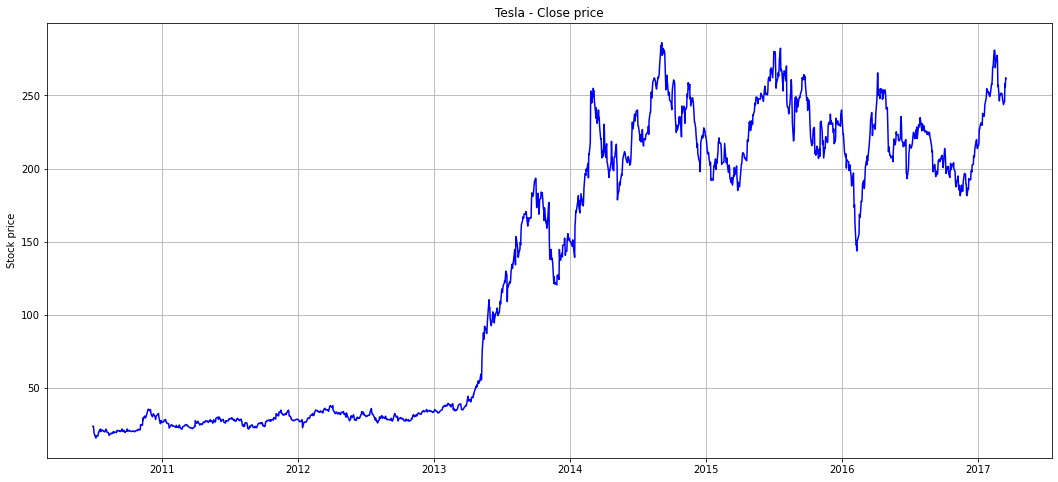

In [34]:
plt.figure(figsize=(18,8))
plt.plot(df['Close'],'b-')
plt.title("Tesla - Close price") 
plt.ylabel("Stock price")
plt.grid()

## Check its stationarity

- The prediction should be more reasonable on the close price.
- from plot above, it seems that is non-stationarity. Let's test about it.

### split chunks to varify mean, variance

In [48]:
close_array = pd.Series(df['Close'].values)
chunks = np.split(close_array,indices_or_sections=9)
print("{}|{:7}|{}".format("chunks","mean","variance"))
print("-"*25)
for i, j in enumerate(chunks,1):
    print("{:6}|{:.6}|{:.6}".format(i, np.mean(j), np.var(j)))

chunks|mean   |variance
-------------------------
     1|23.6027|18.6438
     2|27.5632|7.33095
     3|31.0821|7.76437
     4|46.2839|539.716
     5|164.471|1263.25
     6|230.328|557.292
     7|230.528|680.763
     8|218.87|580.545
     9|219.128|596.781


It has changing means and changing variances.

### Whether is normal distribution

<AxesSubplot:>

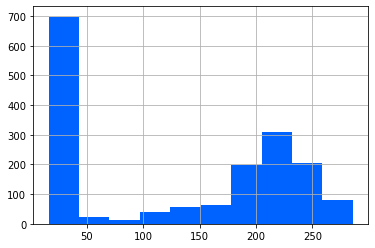

In [49]:
close_array.hist()

It is not normal distribution.

### Statstics - AdFuller test

Addiction to visualization, statstics proving whether it is stationarity helps as well. 

In [53]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['Close'])
print("Adf:",adf)
print("p-value:",pvalue)

Adf: -0.8137329693176628
p-value: 0.8150547908640395


p-value > 0.05 clearly, it is non-stationarity.

# Model preparing

## Split train(2010:2015) and test dataset

In [61]:
close_week = df['Close'].resample('W').mean()

In [62]:
stock_train = close_week['2010':'2015']

<AxesSubplot:xlabel='Date'>

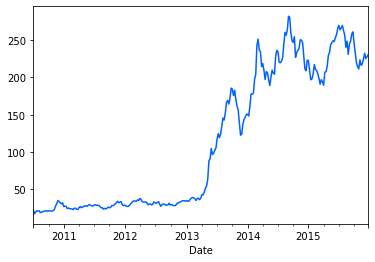

In [64]:
stock_train.plot()

## Differencing - transfor to stationarity

Text(0.5, 1.0, 'Close price after differencing')

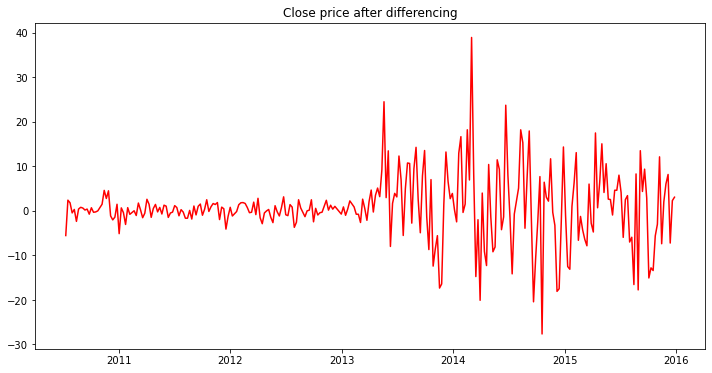

In [65]:
stock_diff = stock_train.diff()
stock_diff = stock_diff.dropna()
plt.figure(figsize=(12,6))
plt.plot(stock_diff,'r-')
plt.title("Close price after differencing")

In [68]:
adfuller(stock_diff)

(-13.684077570268537,
 1.3829853031786577e-25,
 0,
 285,
 {'1%': -3.4535050041524245,
  '5%': -2.8717352599720294,
  '10%': -2.5722024776854417},
 1841.0821374221925)

p-value < 0.05, now after differencing, the stock_diff is stationarity

## ACF, PACF for q,p

In [70]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Text(0.5, 1.0, 'ACF')

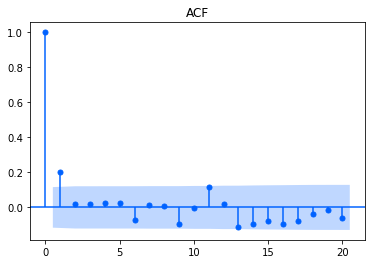

In [71]:
plot_acf(stock_diff,lags=20)
plt.title("ACF")

Text(0.5, 1.0, 'PACF')

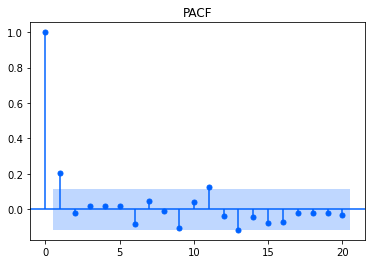

In [72]:
plot_pacf(stock_diff,lags=20)
plt.title("PACF")

From above plots, it seems that q=1, p=1 is preferred.

# ARIMA model

## Parameters choosing from acf, pacf, order=(1,1,1)

In [75]:
from statsmodels.tsa.arima.model import ARIMA

In [79]:
model_1 = ARIMA(stock_train,order=(1,1,1),freq='W').fit()

In [80]:
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  287
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -969.345
Date:                Thu, 28 Apr 2022   AIC                           1944.690
Time:                        10:37:50   BIC                           1955.658
Sample:                    07-04-2010   HQIC                          1949.086
                         - 12-27-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1321      0.190      0.697      0.486      -0.240       0.504
ma.L1          0.0840      0.187      0.451      0.652      -0.282       0.450
sigma2        51.4491      2.571     20.014      0.0

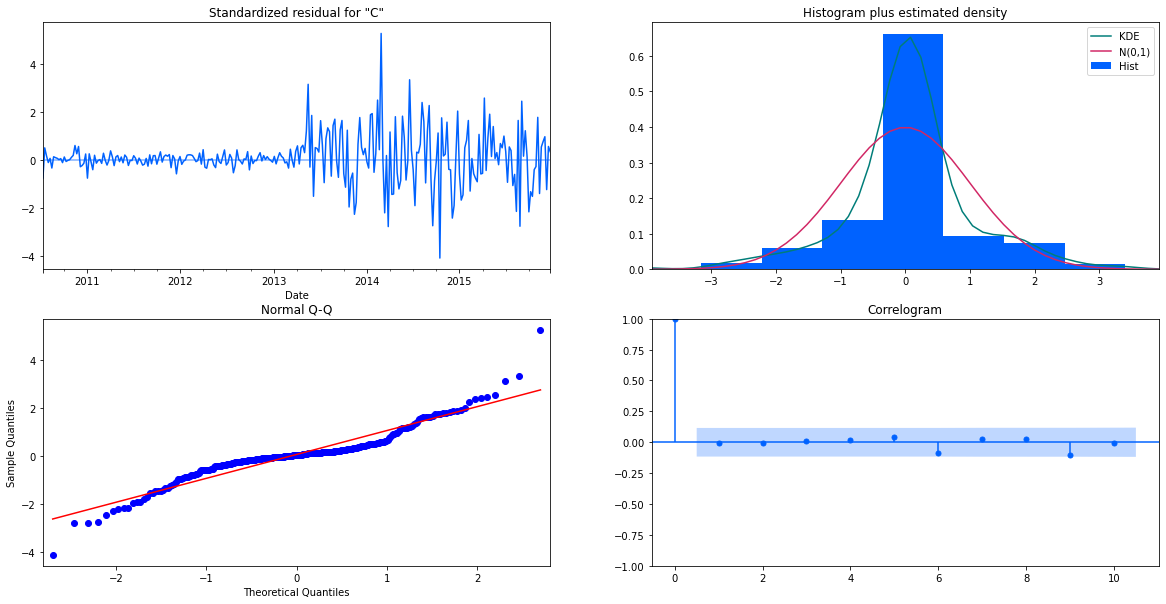

In [83]:
model_1.plot_diagnostics(figsize=(20,10));

In [84]:
close_week.describe() #whole dataset in weeks

count   351.0
mean    132.3
std      94.3
min      16.7
25%      29.9
50%     156.2
75%     220.4
max     282.2
Name: Close, dtype: float64

In [86]:
stock_train.describe() #train set on 2010-2015 in weeks

count   287.0
mean    113.3
std      93.7
min      16.7
25%      28.5
50%      38.8
75%     210.3
max     282.2
Name: Close, dtype: float64

## Prediction using model_1

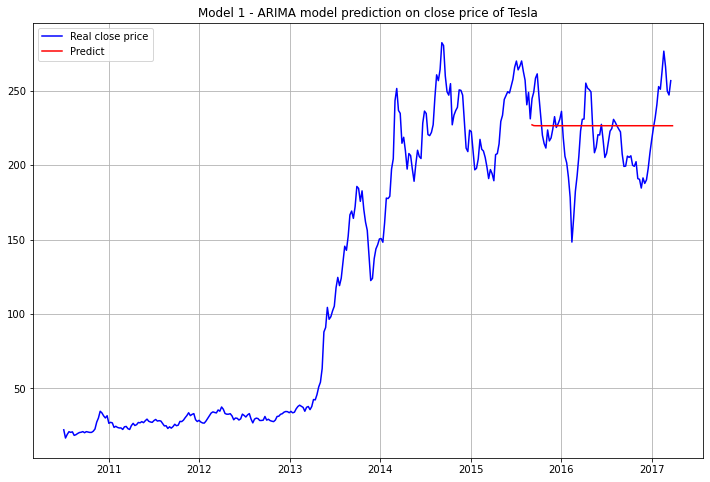

In [128]:
predict_1 = model_1.predict(start=270,end=351,dynamic=True)
plt.figure(figsize=(12,8))
plt.plot(close_week,"b-",label="Real close price")
plt.plot(predict_1,'r-',label='Predict')
plt.legend(loc='best')
plt.title("Model 1 - ARIMA model prediction on close price of Tesla")
plt.grid(0.3)

## Validation : Mse

In [112]:
num_weeks_test = len(predict_1) 
close_test = close_week[-num_weeks_test:] #find the real date matching testing num.

In [113]:
def mse(observation, estimates):
    assert type(observation)==type(np.array([]))
    assert type(estimates)==type(np.array([]))
    assert len(observation)==len(estimates)
    diff = abs(observation) - abs(estimates)
    square = diff **2
    mse = sum(square)
    return mse

In [114]:
mse(close_test.values, predict_1.values)

50246.62748995037

# Pmdarima Model

In [97]:
!pip install pmdarima

     |████████████████████████████████| 595 kB 52 kB/s eta 0:00:011


In [101]:
import pmdarima as pmd

## Parameters from pmd, order=(1,0,1), seasonal=False

In [118]:
model_2 = pmd.auto_arima(stock_train,start_p=0,
                         start_q=0,max_p=3,max_q=3,
                         m=11, d=0, D=1,trace=True,
                         seasonal=False,
                         error_action='ignore',
                         suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3680.755, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1957.680, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1959.475, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1959.510, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2994.108, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1958.405, Time=0.18 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.365 seconds


In [125]:
# comparing model_1 (1,1,1) vs. model_2_best (1,0,1)
model_2_best = ARIMA(stock_train,order=(1,0,1),freq='W').fit()
print(model_1.summary())
print(model_2_best.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  287
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -969.345
Date:                Thu, 28 Apr 2022   AIC                           1944.690
Time:                        14:22:46   BIC                           1955.658
Sample:                    07-04-2010   HQIC                          1949.086
                         - 12-27-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1321      0.190      0.697      0.486      -0.240       0.504
ma.L1          0.0840      0.187      0.451      0.652      -0.282       0.450
sigma2        51.4491      2.571     20.014      0.0

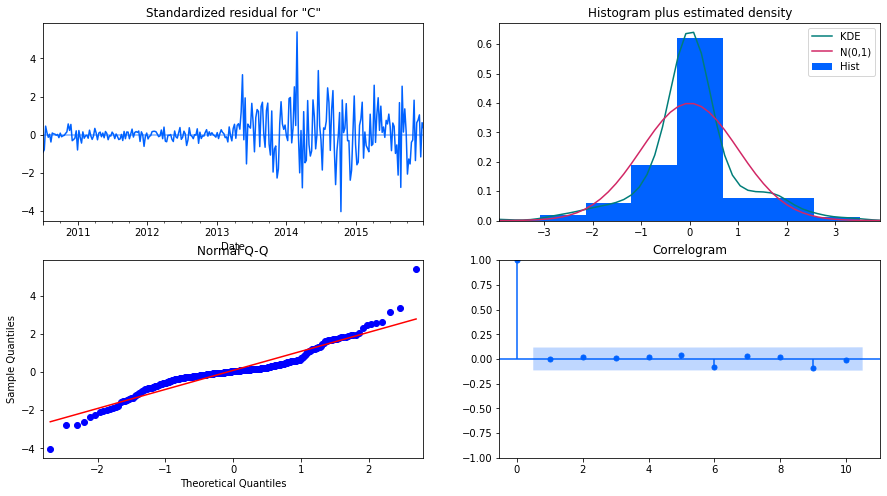

In [121]:
model_2_best.plot_diagnostics(figsize=(15,8));

## Prediction using model_2_best

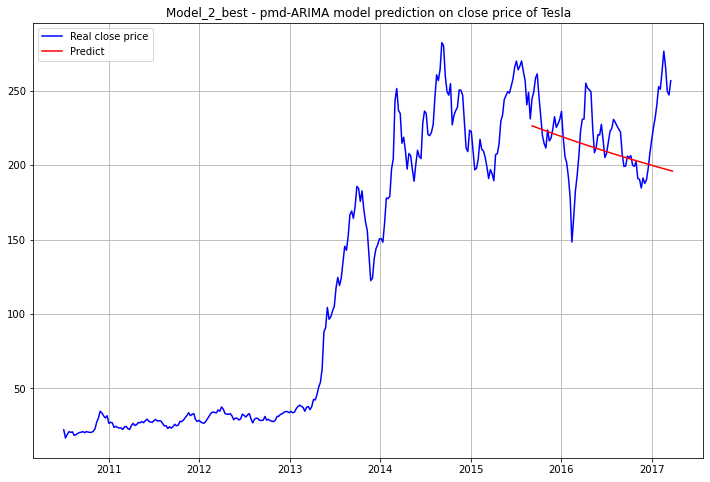

In [129]:
predict_2 = model_2_best.predict(start=270,end=351,dynamic=True)
plt.figure(figsize=(12,8))
plt.plot(close_week,"b-",label="Real close price")
plt.plot(predict_2,'r-',label='Predict')
plt.legend(loc='best')
plt.title("Model_2_best - pmd-ARIMA model prediction on close price of Tesla")
plt.grid(0.3)

## Validation: mse

In [133]:
print("MSE_model_1 (order = (1,1,1)):", mse(close_test.values,predict_1.values))
print("MSE_model_2_best (order = (1,0,1)):",mse(close_test.values, predict_2.values))

MSE_model_1 (order = (1,1,1)): 50246.62748995037
MSE_model_2_best (order = (1,0,1)): 61624.472763307844


## Short Summary 
- from the above comparison of model_1 and model_2, and their mse. 
- Model_1's trend is more accurate than model_2. In this case, model_1 is preferred.

# SARIMA model

In [149]:
import statsmodels.api as sm


## Parameters, best order, seasonal=True

In [137]:
model_3 = pmd.auto_arima(stock_train,start_p=0,
                    start_q=0,max_p=3,max_q=3,
                    m=11, d=0, D=1,trace=True,
                    seasonal=True,
                    error_action='ignore',
                    suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[11] intercept   : AIC=2644.514, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=2648.962, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=1968.474, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=2359.439, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=2667.310, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=2041.734, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=1962.989, Time=0.69 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=2644.308, Time=0.85 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=1952.279, Time=0.94 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=1956.112, Time=0.35 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   : 

In [138]:
print("best order:", model_3.order)
print("best seasonal order:",model_3.seasonal_order)

best order: (2, 0, 1)
best seasonal order: (2, 1, 0, 11)


In [143]:
model_3_best = sm.tsa.statespace.SARIMAX(stock_train, 
                                         order=(2,0,1), 
                                         seasonal_order=(2,1,0,11), 
                                         trend='c').fit()

In [153]:
#comparing model_2 order=(1,0,1) vs. model_3 adding seasonal effect
print(model_2_best.summary())
print(model_3_best.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  287
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -975.209
Date:                Thu, 28 Apr 2022   AIC                           1958.417
Time:                        14:46:03   BIC                           1973.055
Sample:                    07-04-2010   HQIC                          1964.284
                         - 12-27-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.4013    105.105      1.079      0.281     -92.602     319.404
ar.L1          0.9961      0.006    161.999      0.000       0.984       1.008
ma.L1          0.2132      0.047      4.553      0.0

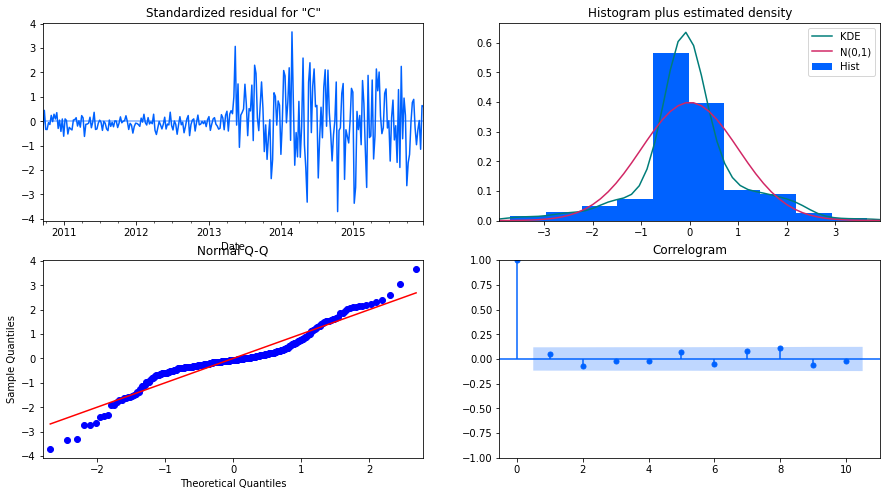

In [152]:
model_3_best.plot_diagnostics(figsize=(15,8));

## Prediction using model_3_best

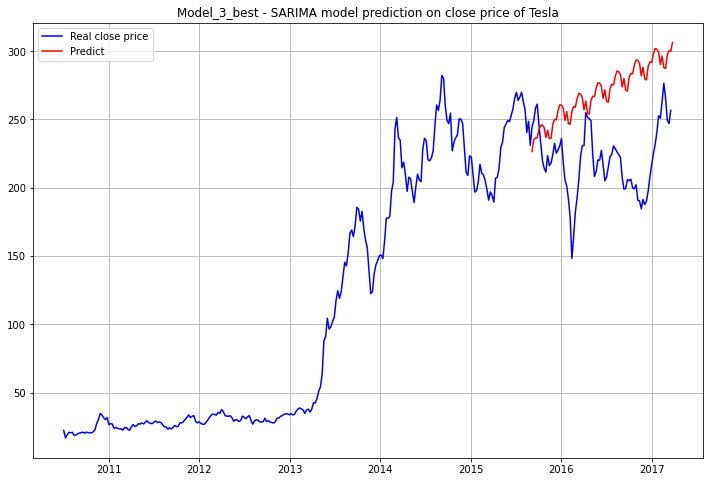

In [155]:
predict_3 = model_3_best.predict(start=270,end=351,dynamic=True)
plt.figure(figsize=(12,8))
plt.plot(close_week,"b-",label="Real close price")
plt.plot(predict_3,'r-',label='Predict')
plt.legend(loc='best')
plt.title("Model_3_best - SARIMA model prediction on close price of Tesla")
plt.grid(0.3)

## Validation: mse

In [158]:
print("MSE of model_1:", mse(close_test.values,predict_1.values))
print("MSE of model_2_best:", mse(close_test.values,predict_2.values))
print("MSE of model_3_best:", mse(close_test.values,predict_3.values))

MSE of model_1: 50246.62748995037
MSE of model_2_best: 61624.472763307844
MSE of model_3_best: 280403.85610155656


# Summary - key findings - Models comparing

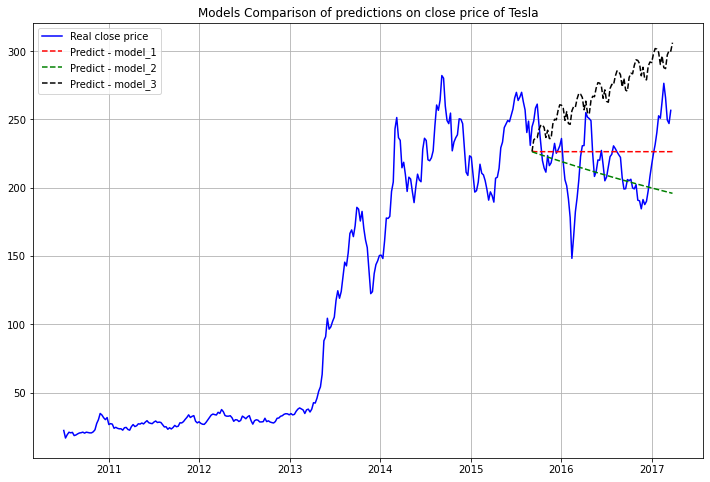

In [162]:
plt.figure(figsize=(12,8))
plt.plot(close_week,"b-",label="Real close price")
plt.plot(predict_1,'r--',label='Predict - model_1')
plt.plot(predict_2,'g--',label='Predict - model_2')
plt.plot(predict_3,'k--',label='Predict - model_3')
plt.legend(loc='best')
plt.title("Models Comparison of predictions on close price of Tesla")
plt.grid(0.3)

- From model_3 prediction plot, it's clearly worse than other models, although some part of trends is similar.
- It shows that adding the seasonal effects in this dataset is misleading the predicted (increasing) trends which is far from real data. 
- Comparing with model_1 and model_2, model_3 is much complicated but has much larger MSE. 
- Model_1's order is much easier got by just checking acf / pacf than getting from pmd arima modeling (model_2, model_3).

- **In this case, from the comparing of ARIMA, pmd-Arima, SARIMA models, the close price prediction will prefer the model_1 ARIMA model as at least final choice (may not the best choice).**

# Insights and Suggestions

-  The first date is at IPO date (2010-6-29), and normally a new stock will have big fluctuations in price after quite few periods. Tesla's stock prices stay stable (<50) for over 2 years. Then, very huge increase with fluctuations come after 2013. It is obviously that,in 2013, there are business actions boosting its stock price, comparing with time sequence factors.

1. What if remove the first "stable" 2 years in the whole data? More stationarity than whole 7 years data. Will it affect on results of model_3?

2. If no changes in original dataset, whether deep learning models will more accurate on predictions? I guess LSTM should get a try.

# Further revisiting (expriment)

## Change train data (2013:2016)

In [163]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.0,25.0,17.5,23.9,18766300,23.9
2010-06-30,25.8,30.4,23.3,23.8,17187100,23.8
2010-07-01,25.0,25.9,20.3,22.0,8218800,22.0
2010-07-02,23.0,23.1,18.7,19.2,5139800,19.2
2010-07-06,20.0,20.0,15.8,16.1,6866900,16.1


In [164]:
new_train = close_week['2013':'2016']

In [165]:
len(new_train)

208

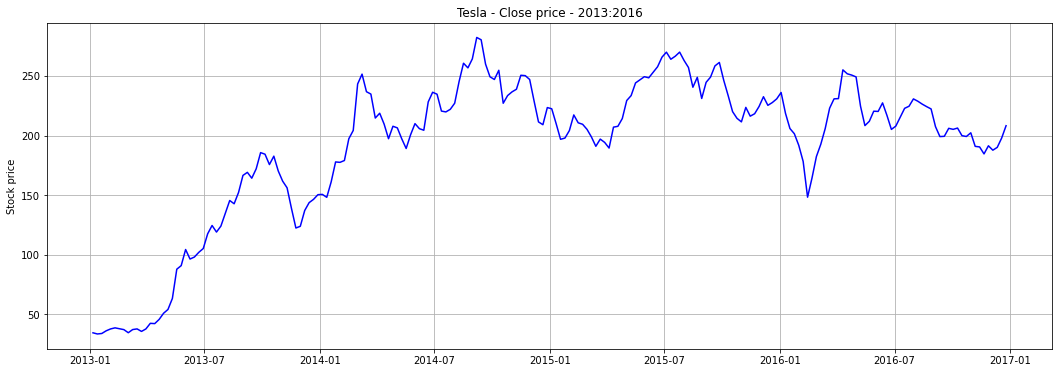

In [168]:
plt.figure(figsize=(18,6))
plt.plot(new_train,'b-')
plt.title("Tesla - Close price - 2013:2016") 
plt.ylabel("Stock price")
plt.grid()

In [180]:
adfuller(new_train)

(-2.6510483882967004,
 0.08289876796155266,
 1,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 1424.3191884328528)

p-value > 0.05, non-stationarity

### transfer to stationarity by differencing

In [172]:
new_train_diff = new_train.diff()
new_train_diff = new_train_diff.dropna()

Text(0.5, 1.0, 'Tesla - train data after differencing')

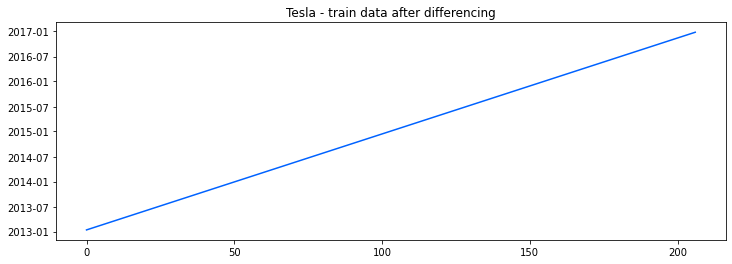

In [177]:
plt.figure(figsize=(12,4))
plt.plot(new_train_diff.index)
plt.title("Tesla - train data after differencing")

In [178]:
adfuller(new_train_diff)

(-11.120357537288317,
 3.4783714548659886e-20,
 0,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 1428.0276199980033)

p-value < 0.05, after differencing, it is stationarity.

### Choosing parameters

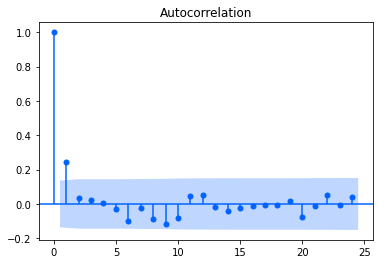

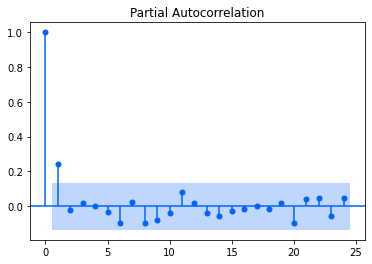

In [183]:
plot_acf(new_train_diff);
plot_pacf(new_train_diff);

It seems very similar to previous acf, pacf plots. p=1, q=1 as well. Skip model_1. Try SARIMA model whether has better result.

### SARIMA model try

In [184]:
model_4 = pmd.auto_arima(new_train,start_p=0,
                    start_q=0,max_p=3,max_q=3,
                    m=11, d=0, D=1,trace=True,
                    seasonal=True,
                    error_action='ignore',
                    suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[11] intercept   : AIC=1998.082, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=2001.797, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=1549.574, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=1792.694, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=2009.906, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=1601.359, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=1543.044, Time=0.72 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=1997.972, Time=0.47 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=1528.060, Time=0.73 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=1533.372, Time=0.32 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   : 

In [188]:
#Very little changes
print("Previous sarima model order:",model_3.order)
print("Previous sarima model seasonal order:",model_3.seasonal_order)
print("New sarima model order:",model_4.order)
print("New sarima model seasonal order:",model_4.seasonal_order)

Previous sarima model order: (2, 0, 1)
Previous sarima model seasonal order: (2, 1, 0, 11)
New sarima model order: (2, 0, 0)
New sarima model seasonal order: (2, 1, 0, 11)


### Prediction with new train, new parameters

In [189]:
model_4_best = sm.tsa.statespace.SARIMAX(new_train, order=(2,0,0),
                                        seasonal_order=(2,1,0,11),
                                        trend='c').fit()

In [191]:
len(new_train)

208

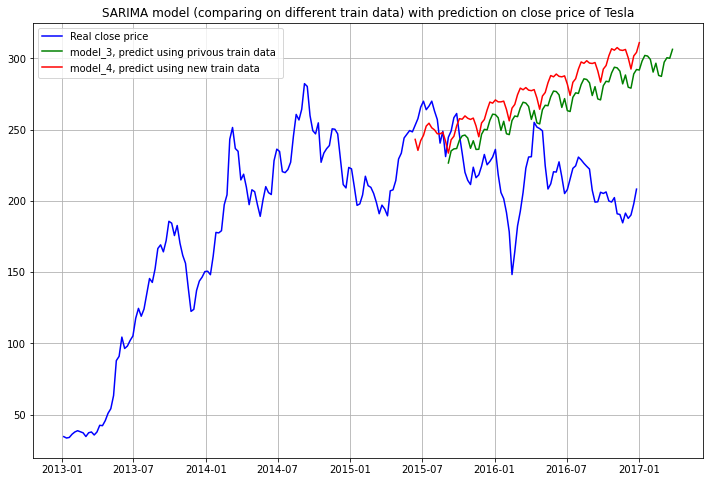

In [199]:
predict_4 = model_4_best.predict(start=208-81,end=208,dynamic=True)
plt.figure(figsize=(12,8))
plt.plot(new_train,"b-",label="Real close price")
plt.plot(predict_3,'g-',label='model_3, predict using privous train data ')
plt.plot(predict_4,'r-',label='model_4, predict using new train data ')
plt.legend(loc='best')
plt.title("SARIMA model (comparing on different train data) with prediction on close price of Tesla")
plt.grid(0.3)

In [201]:
print("previous MSE:", mse(close_test.values, predict_3.values))
print("new Mse:", mse(close_test.values,predict_4.values))

previous MSE: 280403.85610155656
new Mse: 314807.81882714224


**Conclusion:**\
Quite similar in wrong trend. and get Much worse mse...It concludes that changing train data has no effects on results of SARIMA.

## Deep learning model trying- LSTM

### Model preparing

def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-n_days:] 

In [207]:
def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'b-')
    plt.title('{0} Price - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.grid(alpha=0.3)

get_n_last_days(df,'Close',320)


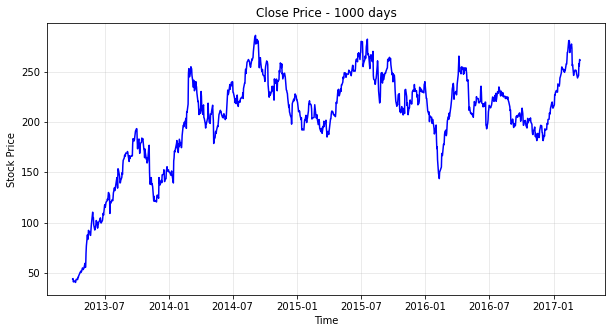

In [267]:
plot_n_last_days(df,'Close',1000)

### split train-test set

In [273]:
data = df.filter(['Close']).values
data

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [255.729996],
       [262.049988],
       [261.5     ]])

In [276]:
import math
train_data_len = math.ceil(len(data)*0.8)
train_data_len

1354

In [308]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
trans_data = scaler.fit_transform(data)
trans_data

array([[0.02993635],
       [0.02971433],
       [0.02279455],
       ...,
       [0.88784039],
       [0.91122698],
       [0.9091918 ]])

In [285]:
train_data = trans_data[0: train_data_len,:]
train_x = []
train_y = []

for i in range(60,len(train_data)):
    train_x.append(train_data[i - 60:i,0])
    train_y.append(train_data[i,0])
    if i<60:
        print(train_x)
        print(train_y)
        print()

In [304]:
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))
train_x.shape

(1294, 60, 1)

In [302]:
test_data = trans_data[train_data_len-60:,:]
test_x = []
test_y = data[train_data_len:,:]
for i in range(60,len(test_data)):
    test_x.append(test_data[i-60:i,0])
test_x = np.array(test_x)
test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))
test_x.shape

(338, 60, 1)

In [303]:
test_y.shape

(338, 1)

### LSTM Model

In [254]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [306]:
model_5 = Sequential()
model_5.add(LSTM(64,input_shape=(train_x.shape[1],1)))
model_5.add(Dense(32))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_squared_error')    
model_5.fit(train_x, train_y,batch_size=1, epochs=10)

Epoch 1/10
1294/1294 [==============================] - 21s 15ms/step - loss: 0.0018
Epoch 2/10
1294/1294 [==============================] - 19s 14ms/step - loss: 9.2596e-04
Epoch 3/10
1294/1294 [==============================] - 18s 14ms/step - loss: 7.2786e-04
Epoch 4/10
1294/1294 [==============================] - 19s 14ms/step - loss: 5.3970e-04
Epoch 5/10
1294/1294 [==============================] - 19s 15ms/step - loss: 6.0790e-04
Epoch 6/10
1294/1294 [==============================] - 19s 15ms/step - loss: 5.2898e-04
Epoch 7/10
1294/1294 [==============================] - 19s 14ms/step - loss: 4.8845e-04
Epoch 8/10
1294/1294 [==============================] - 17s 13ms/step - loss: 4.6672e-04
Epoch 9/10
1294/1294 [==============================] - 17s 13ms/step - loss: 4.9823e-04
Epoch 10/10
1294/1294 [==============================] - 16s 12ms/step - loss: 4.5805e-04


In [307]:
model_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [309]:
predict_5 = model_5.predict(test_x)
predict_5 = scaler.inverse_transform(predict_5)

Due to train_data, test_data is through MinMax transformation, the comparison between prediction and test data on plots should use original data.

In [341]:
train_df = df[:train_data_len]
valid_df = df[train_data_len:]
valid_df['Predict'] = predict_5
valid_df

,Open,High,Low,Close,Volume,Adj Close,Predict
Date,,,,,,,
2015-11-12,217.9,219.0,212.7,212.9,2915900,212.9,217.0
2015-11-13,212.9,213.0,206.5,207.2,3430300,207.2,210.5
2015-11-16,206.1,215.0,205.8,214.3,2925400,214.3,205.4
2015-11-17,215.2,216.0,211.4,214.0,2148700,214.0,213.2
2015-11-18,214.5,221.4,212.5,221.1,2811900,221.1,211.9
...,...,...,...,...,...,...,...
2017-03-13,244.8,246.9,242.8,246.2,3010700,246.2,240.2
2017-03-14,246.1,258.1,246.0,258.0,7575500,258.0,242.8
2017-03-15,257.0,261.0,254.3,255.7,4816600,255.7,254.6


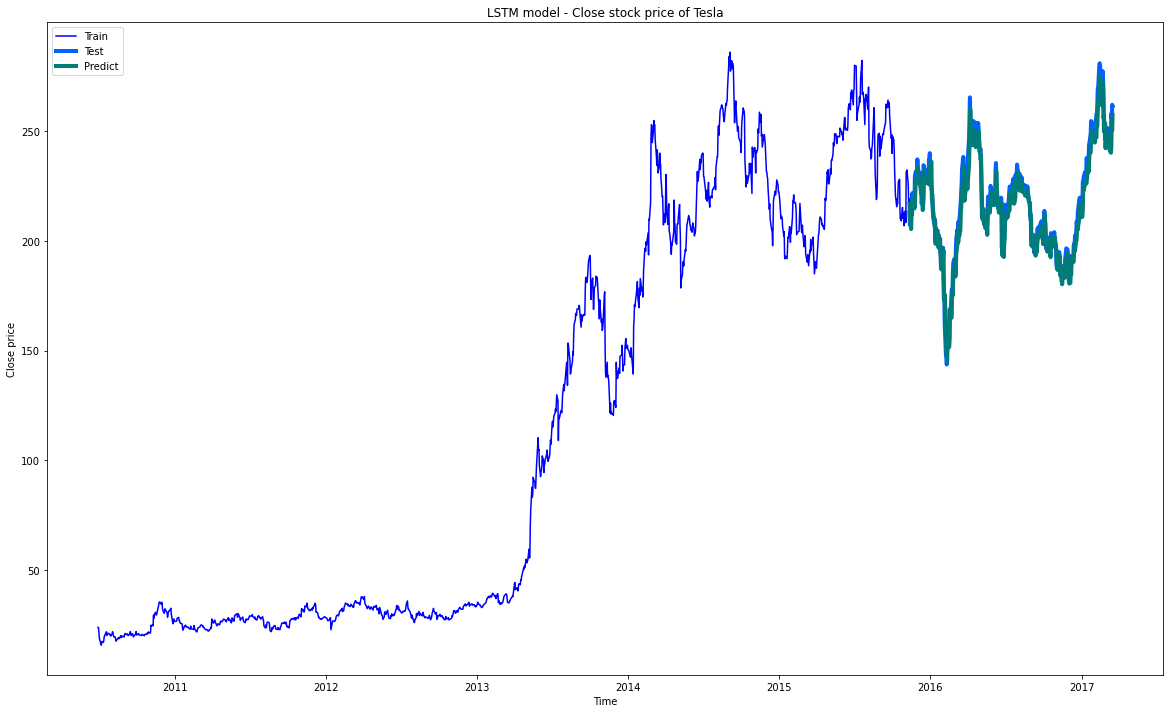

In [345]:
plt.figure(figsize=(20,12))
plt.title("LSTM model - Close stock price of Tesla")
plt.plot(train_df['Close'],'b-')
plt.plot(valid_df[['Close','Predict']],linewidth = 4)
plt.xlabel("Time")
plt.ylabel("Close price")
plt.legend(['Train','Test','Predict'],loc='best');

In [348]:
print("Mse of LSTM model:",mse(test_y, predict_5)[0])
print("Mse of ARIMA model:", mse(close_test.values, predict_1.values))

Mse of LSTM model: 11475.62730693138
Mse of ARIMA model: 50246.62748995037


# Final conclusion: 
-**Comparison of 5 models**

In [373]:
d = {'Model name': ['ARIMA model','PMD-ARIMA model', 'SARIMA model','(NEW)SARIMA model','LSTM model'],
    'Mean square error': [mse(close_test.values, predict_1.values),
                         mse(close_test.values, predict_2.values),
                         mse(close_test.values,predict_3.values),
                         mse(close_test.values,predict_4.values),
                         mse(test_y, predict_5)[0]]}

In [374]:
comparison = pd.DataFrame(data=d)
comparison

,Model name,Mean square error
0,ARIMA model,"50,246.6"
1,PMD-ARIMA model,"61,624.5"
2,SARIMA model,"280,403.9"
3,(NEW)SARIMA model,"314,807.8"
4,LSTM model,"11,475.6"


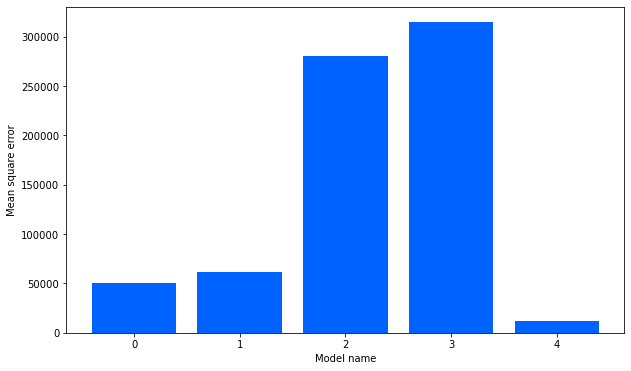

In [396]:
plt.figure(figsize=(10,6))
plt.bar(height=comparison['Mean square error'],x=[0,1,2,3,4])
plt.xlabel('Model name')
plt.ylabel('Mean square error')
plt.show()

**Conclusion:**
- Clearly, LSTM will be the best choice in prediction of stock price via 5 models comparing.
- Predictions(LSTM) are very similar to real data with the lowest MSE.
- Of course, as a disvantage of deep learning models, it often occurs overfitting.